# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=20,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-58-43/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4635 | MulticlassF1Score=0.1556
Batch-30 : CrossEntropyLoss=2.4815 | MulticlassF1Score=0.2030
Batch-45 : CrossEntropyLoss=2.4462 | MulticlassF1Score=0.2302
Batch-60 : CrossEntropyLoss=2.4091 | MulticlassF1Score=0.2920
Batch-75 : CrossEntropyLoss=2.4068 | MulticlassF1Score=0.3359
Batch-90 : CrossEntropyLoss=2.3855 | MulticlassF1Score=0.3678
Batch-105: CrossEntropyLoss=2.4243 | MulticlassF1Score=0.3917
Batch-120: CrossEntropyLoss=2.3761 | MulticlassF1Score=0.4084
Batch-135: CrossEntropyLoss=2.3750 | MulticlassF1Score=0.4280
Batch-150: CrossEntropyLoss=2.3870 | MulticlassF1Score=0.4429
Batch-165: CrossEntropyLoss=2.3873 | MulticlassF1Score=0.4559
Batch-180: CrossEntropyLoss=2.3689 | MulticlassF1Score=0.4668
Batch-195: CrossEntropyLoss=2.3752 | MulticlassF1Score=0.4768
Batch-210: CrossEntropyLoss=2.3727 | MulticlassF1Score=0.4844
Batch-225: CrossEntropyLoss=2.3822 | MulticlassF1Score=0.4921
Batch-226: CrossEntropyLoss=2.3455 | MulticlassF1Score=0.4927

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3664 | MulticlassF1Score=0.6395
Batch-30 : CrossEntropyLoss=2.3666 | MulticlassF1Score=0.6343
Batch-45 : CrossEntropyLoss=2.3633 | MulticlassF1Score=0.6325
Batch-60 : CrossEntropyLoss=2.3639 | MulticlassF1Score=0.6330
Batch-63 : CrossEntropyLoss=2.3794 | MulticlassF1Score=0.6331

Training   : Mean CrossEntropyLoss = 2.4153 | Mean MulticlassF1Score = 0.3633
Validation : Mean CrossEntropyLoss = 2.3639 | Mean MulticlassF1Score = 0.6359

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3624 | MulticlassF1Score=0.6615
Batch-30 : CrossEntropyLoss=2.3608 | MulticlassF1Score=0.6631
Batch-45 : CrossEntropyLoss=2.3541 | MulticlassF1Score=0.6681
Batch-60 : CrossEntropyLoss=2.3464 | MulticlassF1Score=0.6686
Batch-75 : CrossEntropyLoss=2.3294 | MulticlassF1Score=0.6750
Batch-90 : CrossEntropyLoss=2.3343 | MulticlassF1Score=0.6816
Batch-105: CrossEntropyLoss=2.3424 | MulticlassF1Score=0.6860
Batch-120: CrossEntropyLoss=2.3440 | MulticlassF1Score=0.6893
Batch-135: CrossEntropyLoss=2.3342 | MulticlassF1Score=0.6932
Batch-150: CrossEntropyLoss=2.3393 | MulticlassF1Score=0.6960
Batch-165: CrossEntropyLoss=2.3253 | MulticlassF1Score=0.6989
Batch-180: CrossEntropyLoss=2.3390 | MulticlassF1Score=0.7004
Batch-195: CrossEntropyLoss=2.3286 | MulticlassF1Score=0.7025
Batch-210: CrossEntropyLoss=2.3397 | MulticlassF1Score=0.7039
Batch-225: CrossEntropyLoss=2.3280 | MulticlassF1Score=0.7056
Batch-226: CrossEntropyLoss=2.3423 | MulticlassF1Score=0.7057

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3268 | MulticlassF1Score=0.7207
Batch-30 : CrossEntropyLoss=2.3399 | MulticlassF1Score=0.7198
Batch-45 : CrossEntropyLoss=2.3300 | MulticlassF1Score=0.7243
Batch-60 : CrossEntropyLoss=2.3341 | MulticlassF1Score=0.7247
Batch-63 : CrossEntropyLoss=2.3294 | MulticlassF1Score=0.7249

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3402 | Mean MulticlassF1Score = 0.6851
Validation : Mean CrossEntropyLoss = 2.3334 | Mean MulticlassF1Score = 0.7223

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3276 | MulticlassF1Score=0.7253
Batch-30 : CrossEntropyLoss=2.3273 | MulticlassF1Score=0.7290
Batch-45 : CrossEntropyLoss=2.3302 | MulticlassF1Score=0.7287
Batch-60 : CrossEntropyLoss=2.3376 | MulticlassF1Score=0.7275
Batch-75 : CrossEntropyLoss=2.3220 | MulticlassF1Score=0.7258
Batch-90 : CrossEntropyLoss=2.3283 | MulticlassF1Score=0.7258
Batch-105: CrossEntropyLoss=2.3405 | MulticlassF1Score=0.7262
Batch-120: CrossEntropyLoss=2.3367 | MulticlassF1Score=0.7267
Batch-135: CrossEntropyLoss=2.3370 | MulticlassF1Score=0.7269
Batch-150: CrossEntropyLoss=2.3327 | MulticlassF1Score=0.7266
Batch-165: CrossEntropyLoss=2.3321 | MulticlassF1Score=0.7268
Batch-180: CrossEntropyLoss=2.3285 | MulticlassF1Score=0.7269
Batch-195: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7268
Batch-210: CrossEntropyLoss=2.3189 | MulticlassF1Score=0.7262
Batch-225: CrossEntropyLoss=2.3289 | MulticlassF1Score=0.7265
Batch-226: CrossEntropyLoss=2.3253 | MulticlassF1Score=0.7265

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7234
Batch-30 : CrossEntropyLoss=2.3242 | MulticlassF1Score=0.7323
Batch-45 : CrossEntropyLoss=2.3305 | MulticlassF1Score=0.7306
Batch-60 : CrossEntropyLoss=2.3258 | MulticlassF1Score=0.7287
Batch-63 : CrossEntropyLoss=2.3561 | MulticlassF1Score=0.7281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3329 | Mean MulticlassF1Score = 0.7265
Validation : Mean CrossEntropyLoss = 2.3322 | Mean MulticlassF1Score = 0.7286

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3407 | MulticlassF1Score=0.7315
Batch-30 : CrossEntropyLoss=2.3257 | MulticlassF1Score=0.7311
Batch-45 : CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7361
Batch-60 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7469
Batch-75 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.7550
Batch-90 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7614
Batch-105: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7660
Batch-120: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7693
Batch-135: CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7718
Batch-150: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7743
Batch-165: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7767
Batch-180: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.7784
Batch-195: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7795
Batch-210: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7805
Batch-225: CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7820
Batch-226: CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7819

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7963
Batch-30 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7938
Batch-45 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7944
Batch-60 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7953
Batch-63 : CrossEntropyLoss=2.3216 | MulticlassF1Score=0.7948

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3157 | Mean MulticlassF1Score = 0.7616
Validation : Mean CrossEntropyLoss = 2.3113 | Mean MulticlassF1Score = 0.7950

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7943
Batch-30 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7956
Batch-45 : CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7948
Batch-60 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.7959
Batch-75 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7955
Batch-90 : CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7964
Batch-105: CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7974
Batch-120: CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7984
Batch-135: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.7999
Batch-150: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8019
Batch-165: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8035
Batch-180: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8045
Batch-195: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8054
Batch-210: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8061
Batch-225: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8069
Batch-226: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8070

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8251
Batch-30 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8178
Batch-45 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8168
Batch-60 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8172
Batch-63 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8175

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3077 | Mean MulticlassF1Score = 0.7990
Validation : Mean CrossEntropyLoss = 2.3041 | Mean MulticlassF1Score = 0.8191

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8236
Batch-30 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8281
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8291
Batch-60 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8299
Batch-75 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8296
Batch-90 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8293
Batch-105: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8297
Batch-120: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8303
Batch-135: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8294
Batch-150: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8296
Batch-165: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8301
Batch-180: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8306
Batch-195: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8310
Batch-210: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8307
Batch-225: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8312
Batch-226: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8312

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8295
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8305
Batch-45 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8281
Batch-60 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8290
Batch-63 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8289

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8285
Validation : Mean CrossEntropyLoss = 2.3007 | Mean MulticlassF1Score = 0.8292

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.8286
Batch-30 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8286
Batch-45 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8305
Batch-60 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8313
Batch-75 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8322
Batch-90 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8334
Batch-105: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8342
Batch-120: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8336
Batch-135: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8335
Batch-150: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8334
Batch-165: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8338
Batch-180: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8337
Batch-195: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8333
Batch-210: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8329
Batch-225: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8332
Batch-226: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8332

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8313
Batch-30 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8288
Batch-45 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8293
Batch-60 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8302
Batch-63 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8305

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2994 | Mean MulticlassF1Score = 0.8327
Validation : Mean CrossEntropyLoss = 2.3001 | Mean MulticlassF1Score = 0.8295

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8336
Batch-30 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8346
Batch-45 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8350
Batch-60 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8350
Batch-75 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8361
Batch-90 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8361
Batch-105: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8366
Batch-120: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8361
Batch-135: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8357
Batch-150: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8359
Batch-165: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8359
Batch-180: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8356
Batch-195: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8355
Batch-210: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8352
Batch-225: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8352
Batch-226: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8351

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8292
Batch-30 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8294
Batch-45 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8297
Batch-60 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8300
Batch-63 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8304

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8356
Validation : Mean CrossEntropyLoss = 2.3001 | Mean MulticlassF1Score = 0.8301

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8408
Batch-30 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8402
Batch-45 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8391
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8387
Batch-75 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8384
Batch-90 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8375
Batch-105: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8378
Batch-120: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8372
Batch-135: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8367
Batch-150: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8370
Batch-165: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8370
Batch-180: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8372
Batch-195: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8373
Batch-210: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8369
Batch-225: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8366
Batch-226: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8365

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8268
Batch-30 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8292
Batch-45 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8310
Batch-60 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8314
Batch-63 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8315

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8381
Validation : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8294

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8388
Batch-30 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8373
Batch-45 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8363
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8381
Batch-75 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8431
Batch-90 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8465
Batch-105: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8485
Batch-120: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8503
Batch-135: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8518
Batch-150: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8526
Batch-165: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8539
Batch-180: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8546
Batch-195: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8551
Batch-210: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8560
Batch-225: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8568
Batch-226: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8568

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8620
Batch-30 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8614
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8619
Batch-60 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8599
Batch-63 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8602

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2922 | Mean MulticlassF1Score = 0.8475
Validation : Mean CrossEntropyLoss = 2.2912 | Mean MulticlassF1Score = 0.8604

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8715
Batch-30 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8691
Batch-45 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8674
Batch-60 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8668
Batch-75 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8654
Batch-90 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8664
Batch-105: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8663
Batch-120: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8664
Batch-135: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8668
Batch-150: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8673
Batch-165: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8687
Batch-180: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8700
Batch-195: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8714
Batch-210: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8720
Batch-225: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8726
Batch-226: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8727

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8786
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8771
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8770
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8759
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8764

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2874 | Mean MulticlassF1Score = 0.8684
Validation : Mean CrossEntropyLoss = 2.2861 | Mean MulticlassF1Score = 0.8772

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8836
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.8951
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9001
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9052
Batch-75 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9073
Batch-90 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9083
Batch-105: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9086
Batch-120: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9092
Batch-135: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9099
Batch-150: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9102
Batch-165: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9111
Batch-180: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9111
Batch-195: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9121
Batch-210: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9126
Batch-225: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9130
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9131

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9124
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9126
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9104
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9103
Batch-63 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9096

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9055
Validation : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9115

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9184
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9188
Batch-45 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9207
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9204
Batch-90 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9194
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9195
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9197
Batch-135: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9197
Batch-150: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9198
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9201
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9200
Batch-195: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9199
Batch-210: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9200
Batch-225: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9197
Batch-226: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9197

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9097
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9085
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9095
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9096
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9098

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9198
Validation : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9094

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9234
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9207
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9213
Batch-90 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9207
Batch-105: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9213
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9219
Batch-135: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9216
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9214
Batch-165: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9213
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9214
Batch-195: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9212
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9210
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9209
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9209

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9043
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9066
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9096
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9109
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9110

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9216
Validation : Mean CrossEntropyLoss = 2.2754 | Mean MulticlassF1Score = 0.9066

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9247
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9243
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9238
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9237
Batch-120: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9237
Batch-135: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9239
Batch-150: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9240
Batch-165: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9237
Batch-180: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9235
Batch-195: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9234
Batch-210: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9236
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9235
Batch-226: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9234

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9140
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9127
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9120
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9120
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9121

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9239
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9119

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9233
Batch-75 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9255
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9263
Batch-105: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9274
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9281
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9289
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9294
Batch-165: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9299
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9301
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9299
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9301
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9307
Batch-226: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9307

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9250
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9214
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9213
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9206
Batch-63 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9204

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9268
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9238

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9337
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9336
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9337
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9333
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9343
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9349
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9350
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9348
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9346
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9346
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9343
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9344
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9346
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9345
Batch-226: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9344

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9205
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9206
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9206

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9340
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9224

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9373
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9352
Batch-75 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9363
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9370
Batch-105: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9366
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9364
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9361
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9357
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9352
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9350
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9349
Batch-225: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9347
Batch-226: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9347

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9203
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9204
Batch-63 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9202

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9360
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9208

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9293
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9323
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9341
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9347
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9345
Batch-105: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9337
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9339
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9341
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9342
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9347
Batch-180: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9349
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9353
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9353
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9352
Batch-226: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9352

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9192
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9206
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9205
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9204
Batch-63 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9338
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9208

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9336
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9347
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9349
Batch-75 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9357
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9355
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9361
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9361
Batch-135: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9358
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9358
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9359
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9361
Batch-210: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9360
Batch-225: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9359
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9360

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9210

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9355
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9229

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9364
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9356
Batch-75 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9355
Batch-90 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9363
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9362
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9364
Batch-135: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9367
Batch-150: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9365
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9365
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9366
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9369
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9361
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9225

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9368
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9379
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9384
Batch-75 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9380
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9374
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9376
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9374
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9373
Batch-150: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9377
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9378
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9375
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9376
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9376
Batch-226: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9376

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9180
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9217
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9379
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9204

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9379
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9370
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9374
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9372
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9374
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9373
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9374
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9376
Batch-180: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9380
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9382
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9382
Batch-226: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9382

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9218
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9214
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9216

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9377
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9210

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9386
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9388
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9389
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9395
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9397
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9388
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9392
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9387
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9386
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9385
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9384
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9384

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9221
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9213
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9216

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9227

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9388
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9400
Batch-75 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9388
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9393
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9391
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9390
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9389
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9390
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9391
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9389
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9387
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9387
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9386

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9223
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9229

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9390
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9387
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9389
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9388
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9389
Batch-165: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9390
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9392
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9390
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9390

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9214
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9223

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9395
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9402
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9398
Batch-105: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9396
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9393
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9395
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9394
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9242

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9396
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9223

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9413
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9414
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9414
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9419
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9415
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9415
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9414
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9238
Batch-63 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9244

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9428
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9425
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9423
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9420
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9420
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9422
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9421
Batch-225: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9418
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9418

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9423
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9222

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9423
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9418
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9419
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9417
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9419
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9420
Batch-180: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9421
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9421
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9247
Batch-63 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9244

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9423
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9257

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9442
Batch-75 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9440
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9433
Batch-195: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9430
Batch-226: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9430

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9440
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9259

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9428
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9432
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9434
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9243

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9432
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9433
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9435
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9434
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9244

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9447
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9442
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9450
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9442
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9446
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9446

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9269

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9265

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9448
Batch-105: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9447
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9451
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9452
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9452
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9274
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9281
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9279

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9451
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9274

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9467
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9469
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9468
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9467
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9471
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9472

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9250

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9482
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9484
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9485
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9485
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9486
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9489
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9486
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9482
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9478
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9479
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9476
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9477

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9289

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9481
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9261

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9475
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9487
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9489
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9489
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9487
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9487
Batch-226: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9487

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9296
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9297
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9296
Batch-63 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9298

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9480
Validation : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9289

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9511
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9506
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9507
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9506
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9511
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9507
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9509
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9506
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9505
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9504
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9504
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9504
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9503
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9503
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9504

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9307
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9310
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9310
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9305
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9307

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2628 | Mean MulticlassF1Score = 0.9502
Validation : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9306

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9512
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9517
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9508
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9509
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9512
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9512
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9509
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9506
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9507
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9508
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9507
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9509
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9507
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9506
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9506
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9507

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9338
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9324
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9305
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9300
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9303

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2627 | Mean MulticlassF1Score = 0.9510
Validation : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9325

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9520
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9524
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9509
Batch-75 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9505
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9508
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9507
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9508
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9510
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9509
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9509
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9512
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9512
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9512
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9509
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9509

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9312
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9298
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9305
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9307

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9510
Validation : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9302

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9511
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9525
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9527
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9521
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9522
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9524
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9520
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9516
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9514
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9516
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9515
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9513
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9510
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9510
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9510

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9322
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9323
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9302
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9306
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9307

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9517
Validation : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9312

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9510
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9500
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9507
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9507
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9509
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9511
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9513
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9514
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9514
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9512
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9514
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9512
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9512
Batch-226: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9512

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9298
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9303
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9303

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2625 | Mean MulticlassF1Score = 0.9507
Validation : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9302

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9520
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9515
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9514
Batch-75 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9514
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9510
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9512
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9511
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9516
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9516
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9515
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9516
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9514
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9514
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9512
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9512

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9293
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9299
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9302
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9304

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2625 | Mean MulticlassF1Score = 0.9514
Validation : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9301

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9513
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9518
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9525
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9520
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9524
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9527
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9526
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9524
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9520
Batch-165: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9517
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9518
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9520
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9520
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9520
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9520

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9312
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9333
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9315
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9304
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9311

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2623 | Mean MulticlassF1Score = 0.9519
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9319

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9526
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9515
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9516
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9515
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9521
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9530
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9528
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9527
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9524
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9523
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9524
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9522
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9526
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9524
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9524

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9309
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9315
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9322
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9316
Batch-63 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9315

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2621 | Mean MulticlassF1Score = 0.9522
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9309

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9540
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9541
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9547
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9553
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9550
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9567
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9586
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9600
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9612
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9619
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9627
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9635
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9650
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9495

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9592
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9500

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9713
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9722
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9720
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9720
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9720
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9722
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9723
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9724
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9723
Batch-210: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9723
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9506
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9497
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9500

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9498

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9721
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9727
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9726
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9726
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9727
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9723
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9721
Batch-135: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9721
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9724
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9723
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9721
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9720
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9720
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9507
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9502

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9722
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9499
Patience = 1/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9718
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9724
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9721
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9728
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9732
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9735
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9732
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9732
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9730
Batch-165: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9733
Batch-180: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9733
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9730
Batch-210: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9729
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9728
Batch-226: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9728

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9535
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9514
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9509

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2559 | Mean MulticlassF1Score = 0.9729
Validation : Mean CrossEntropyLoss = 2.2627 | Mean MulticlassF1Score = 0.9515

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2559
Best CrossEntropyLoss training    : 2.2627
Best MulticlassF1Score validation : 0.9729
Best MulticlassF1Score validation : 0.9515
Training duration                 : 2.7181 minutes.
Training date                     : 2022-10-19 14:34:31.027734+08:00


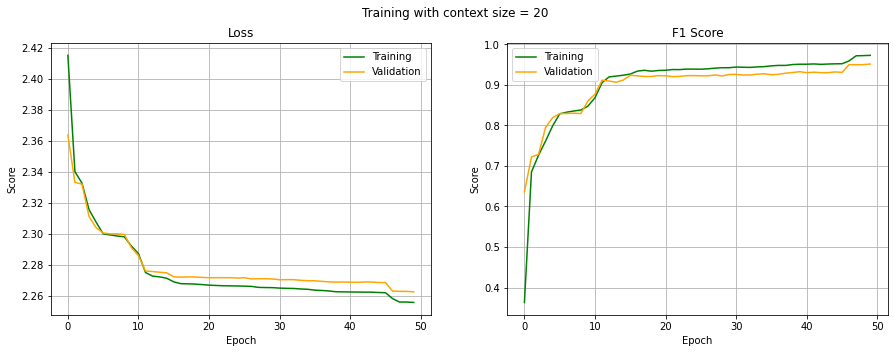

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9736, device='cuda:0'),
 tensor(0.9509, device='cuda:0'),
 tensor(0.9483, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9736, device='cuda:0'),
 tensor(0.9509, device='cuda:0'),
 tensor(0.9483, device='cuda:0'))

## Heatmap

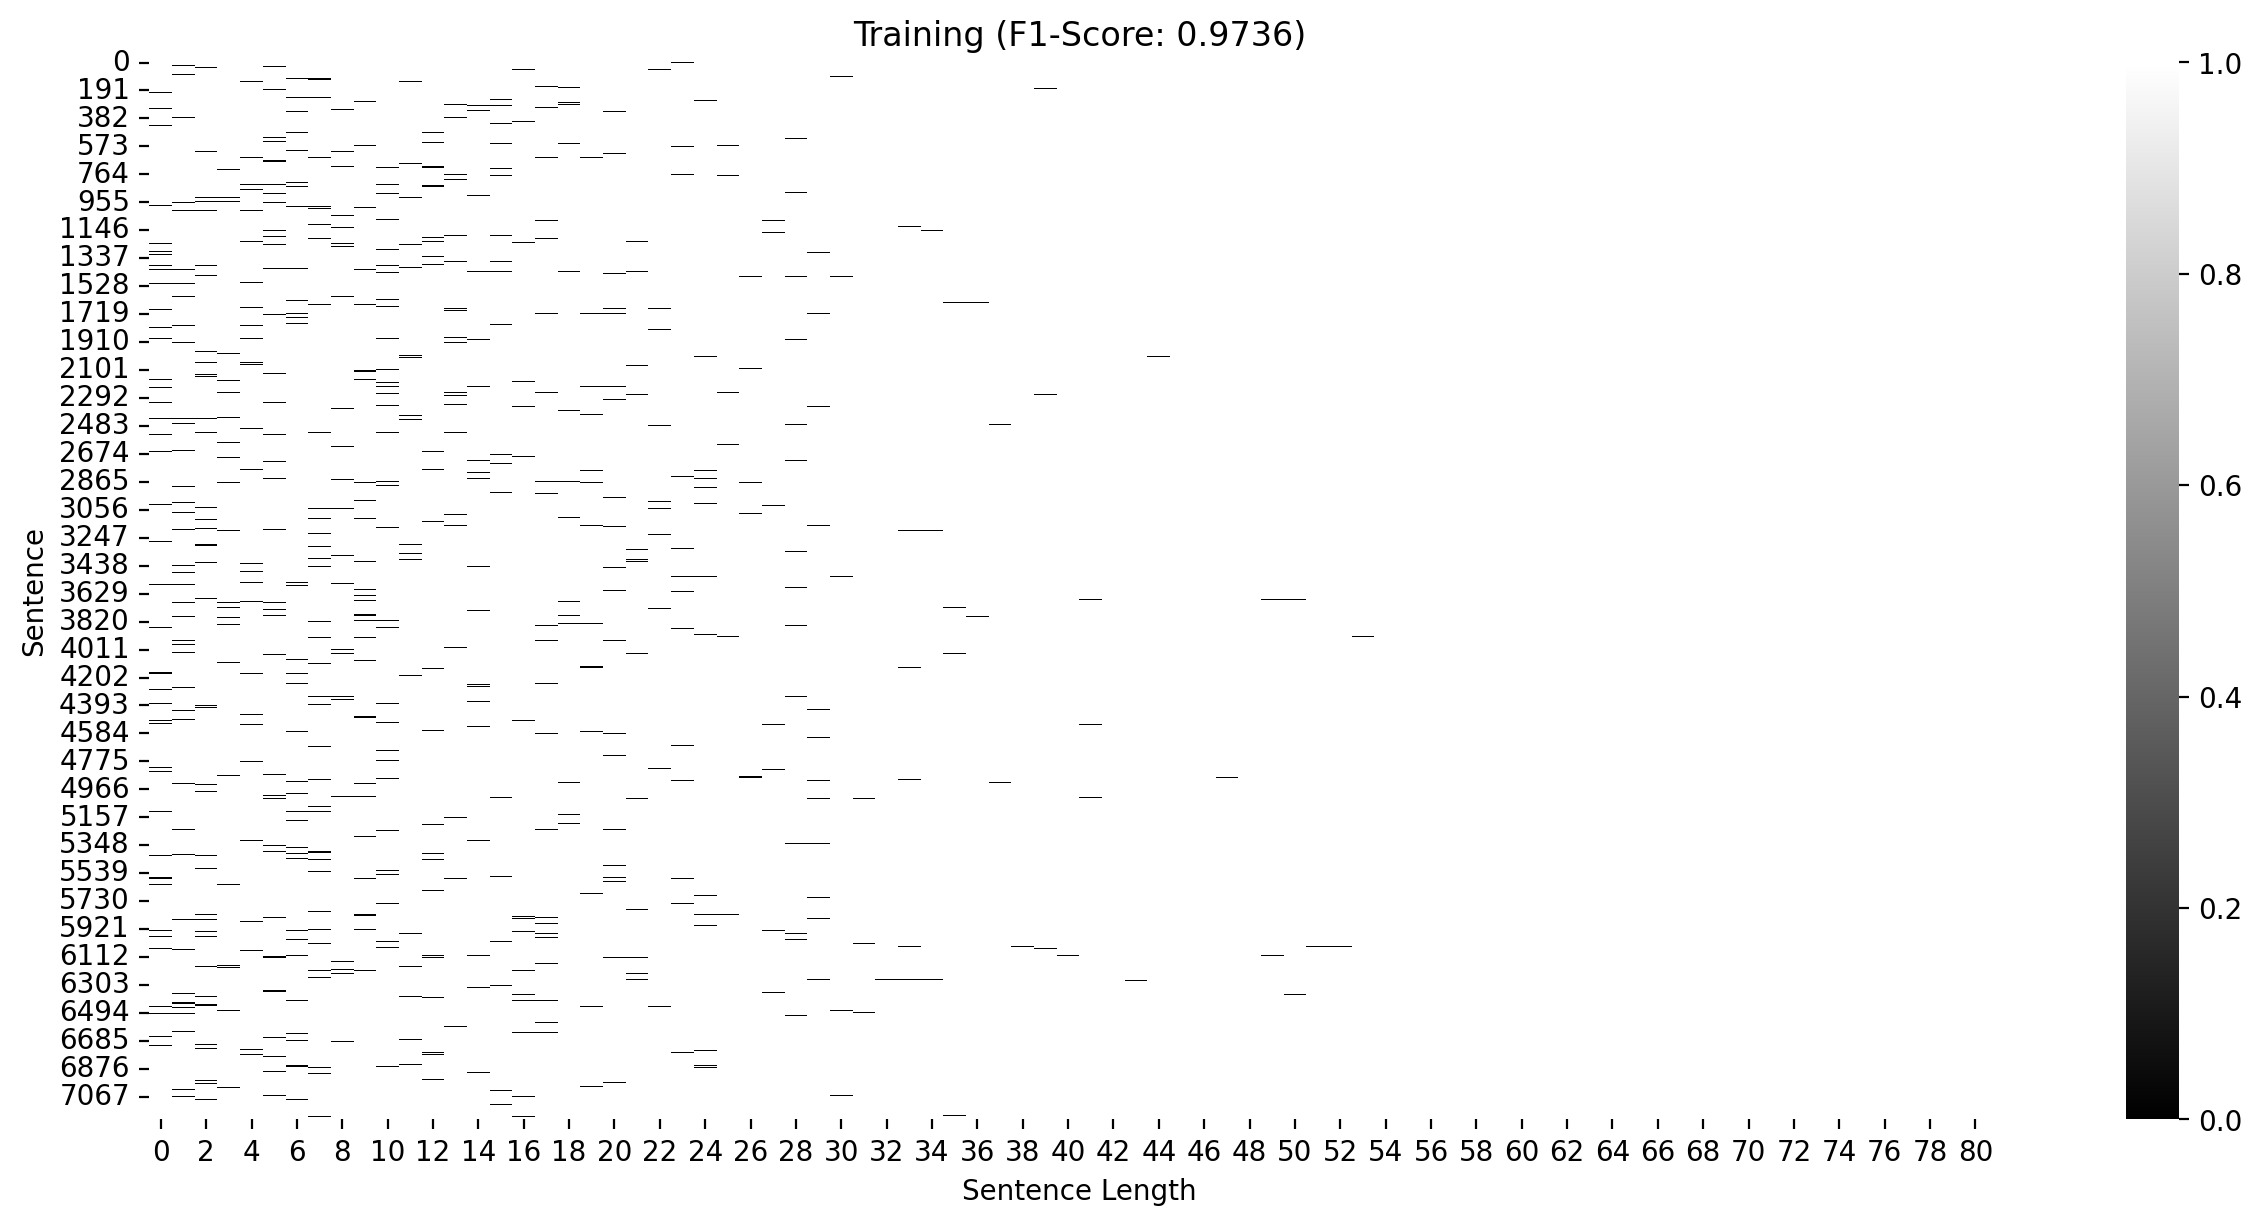

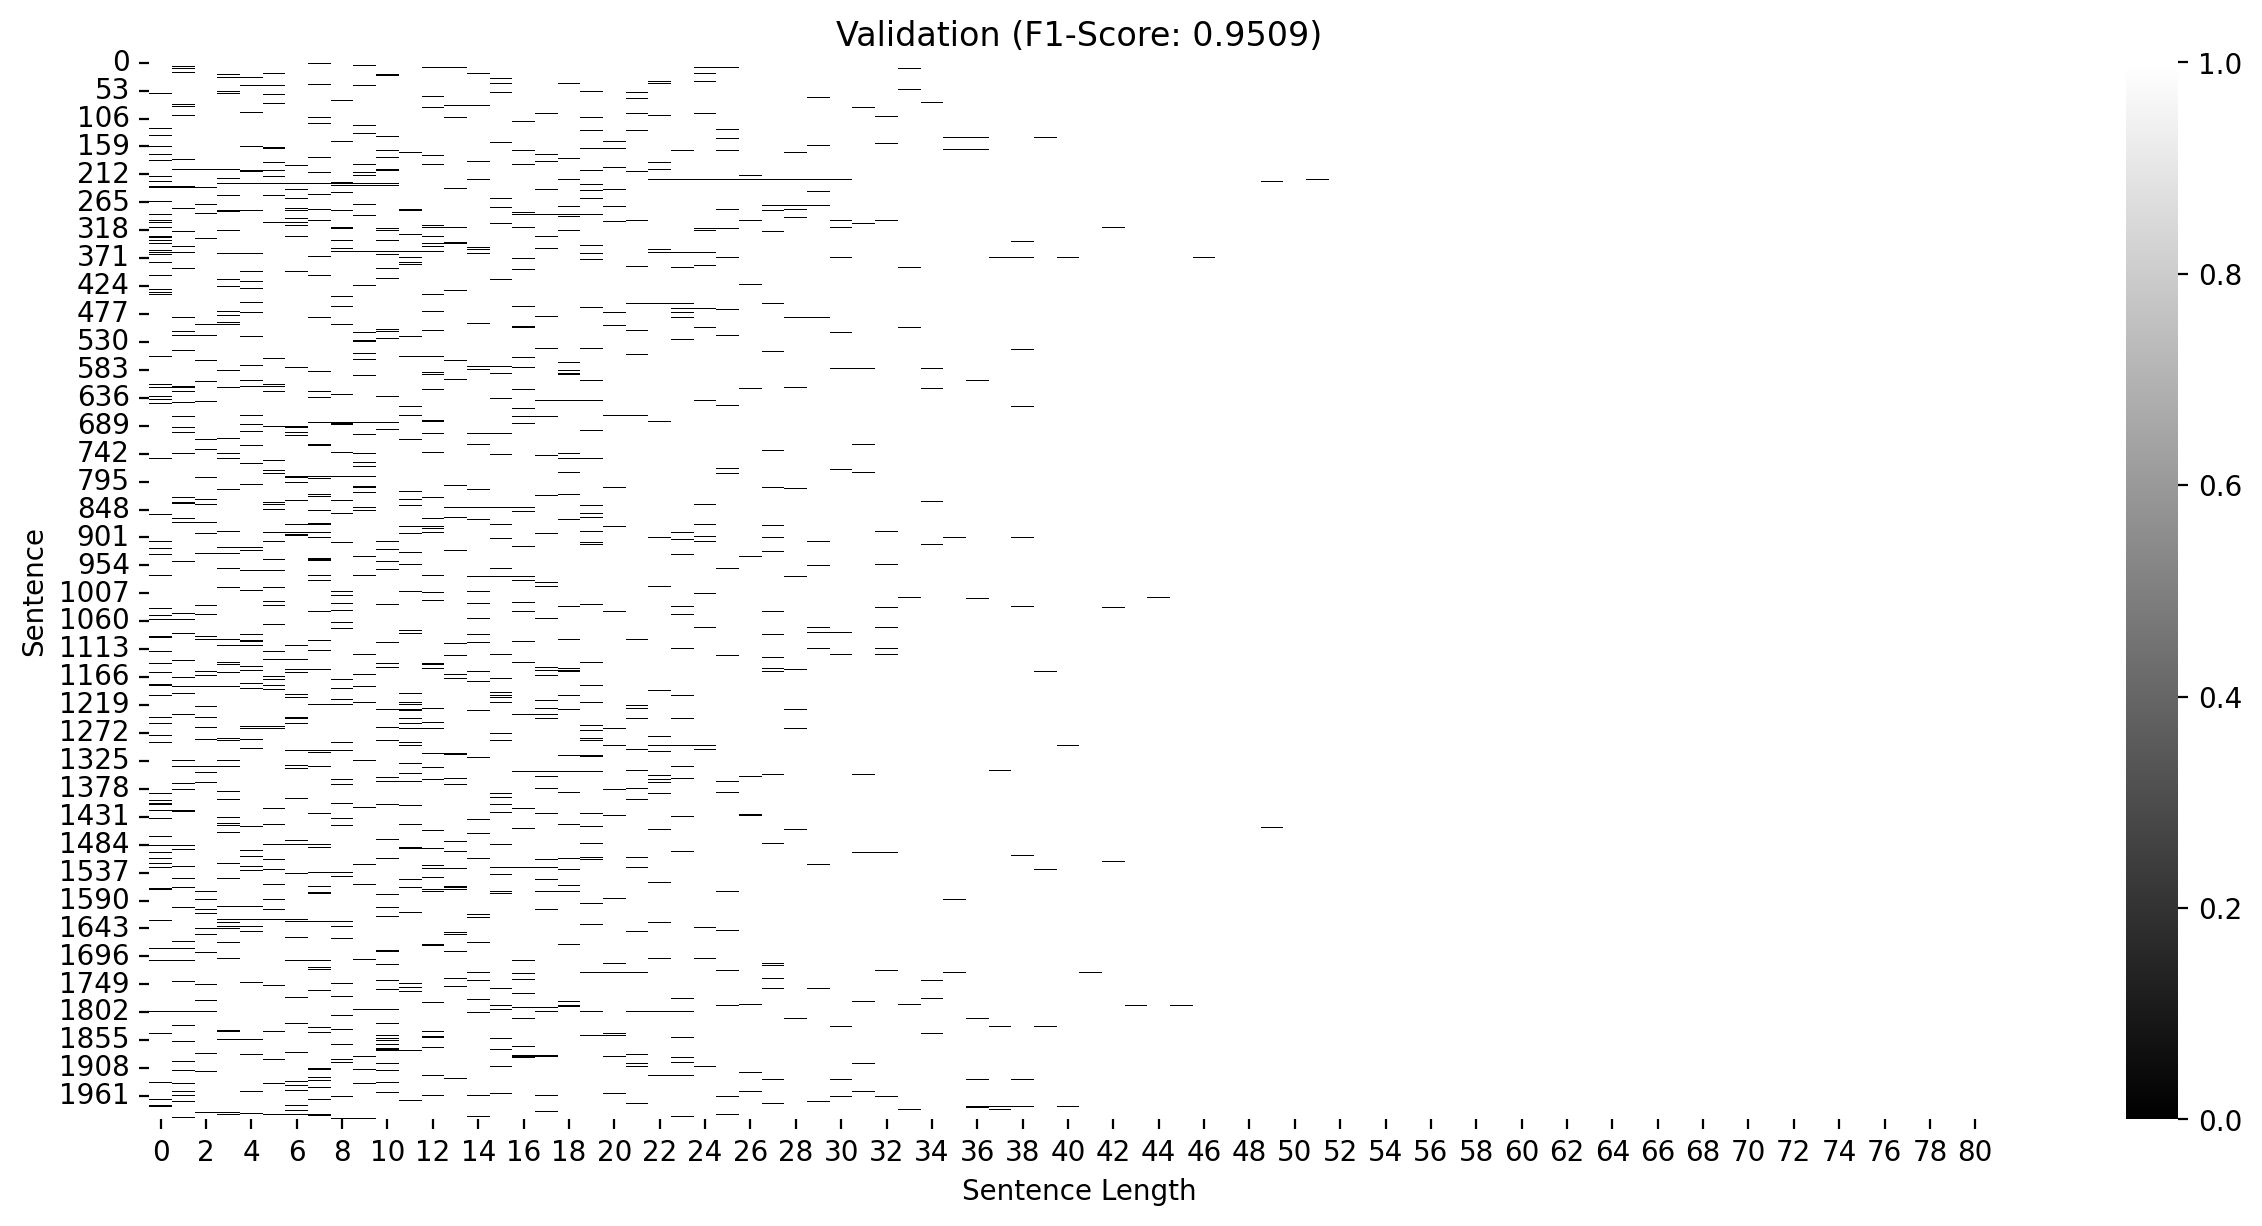

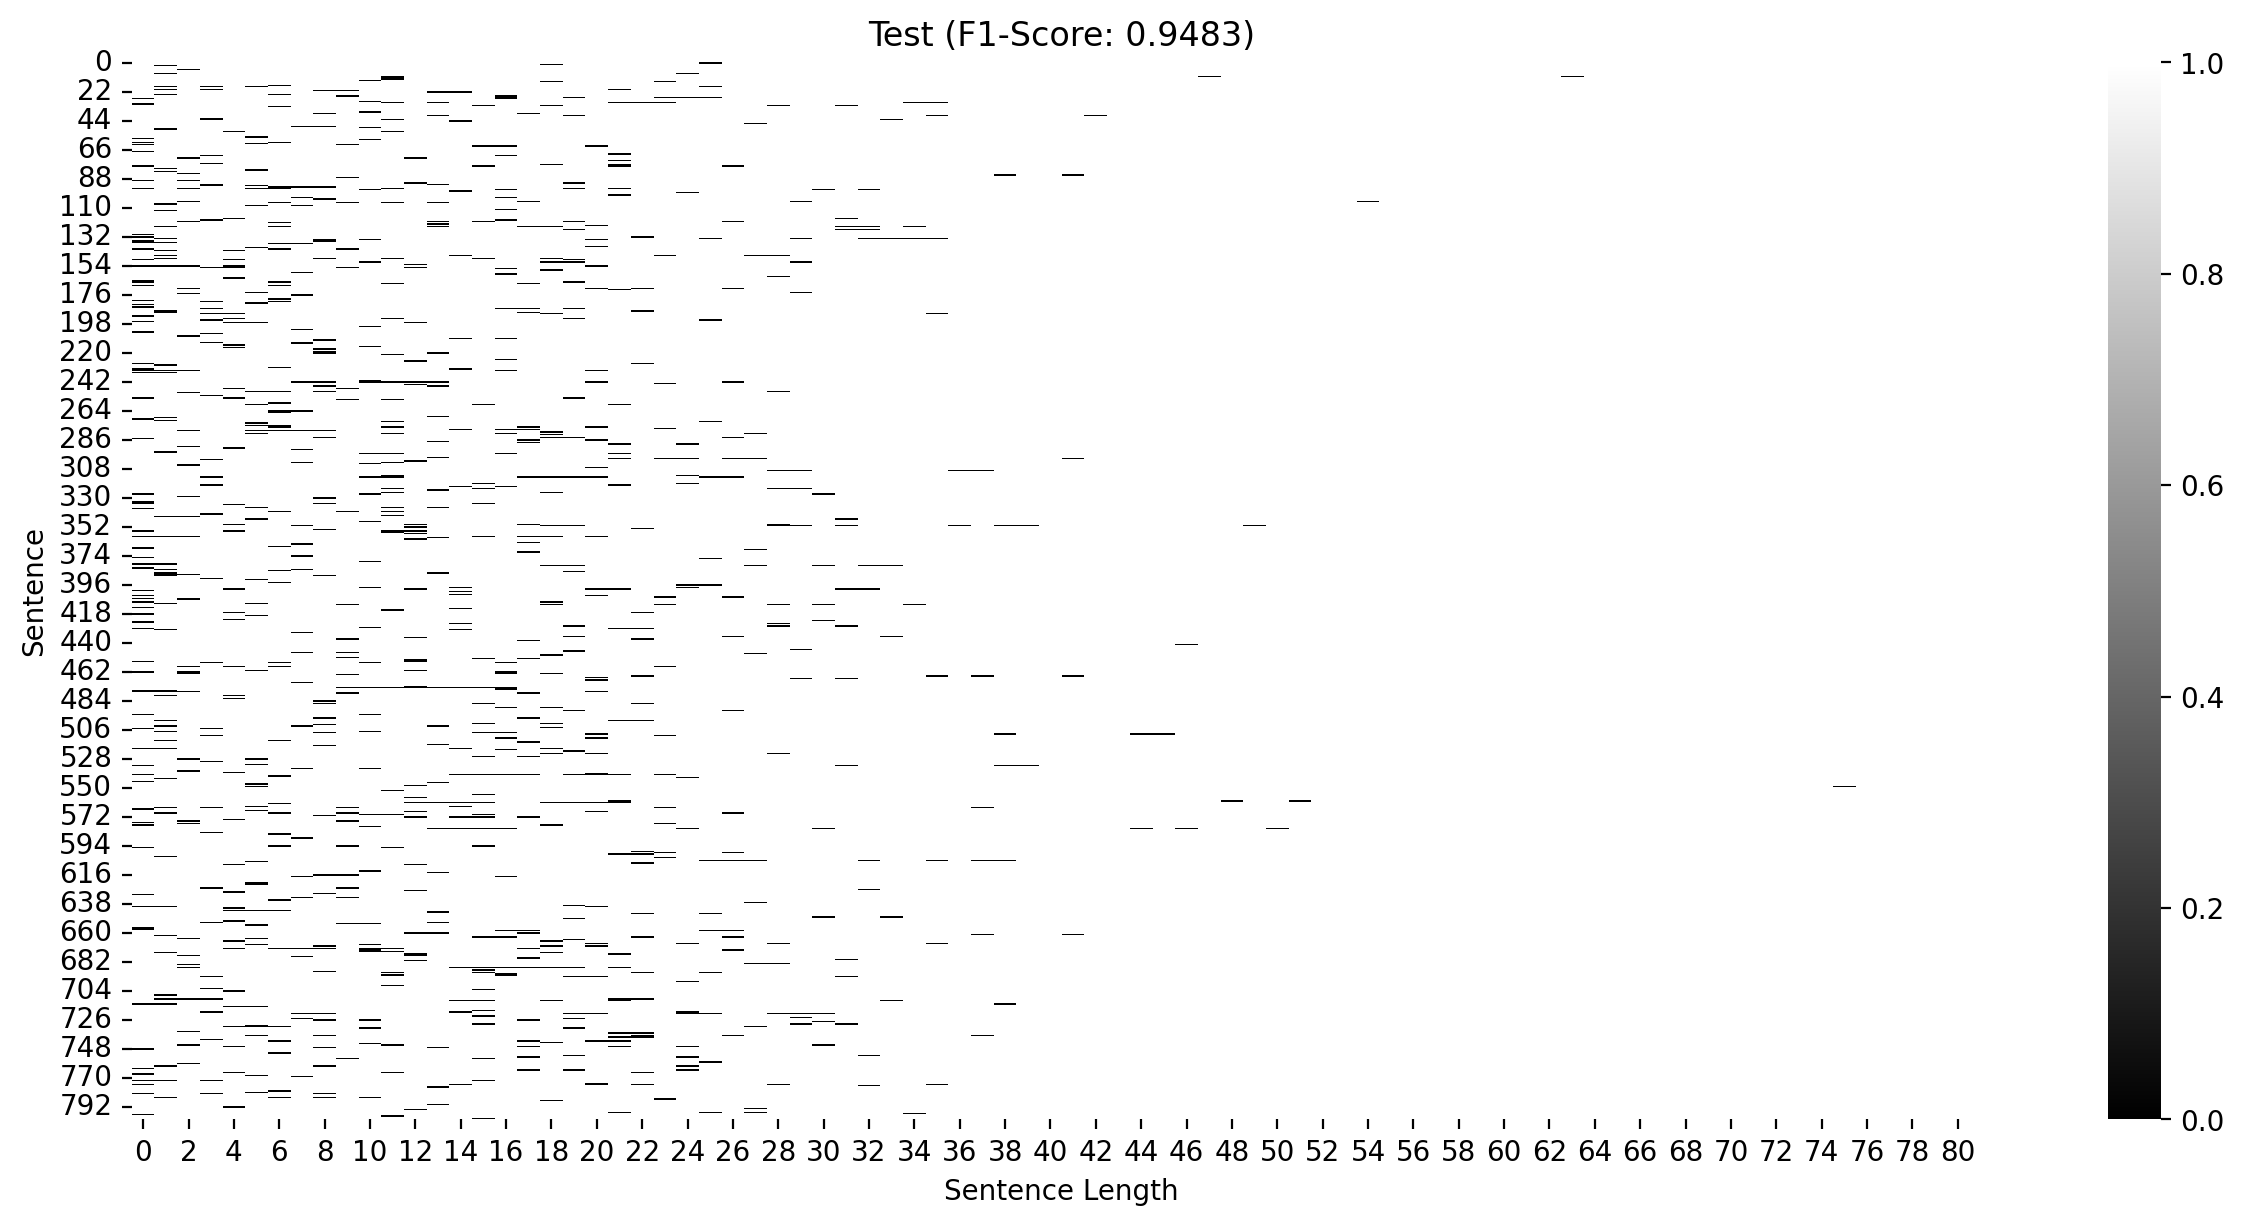

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 72 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


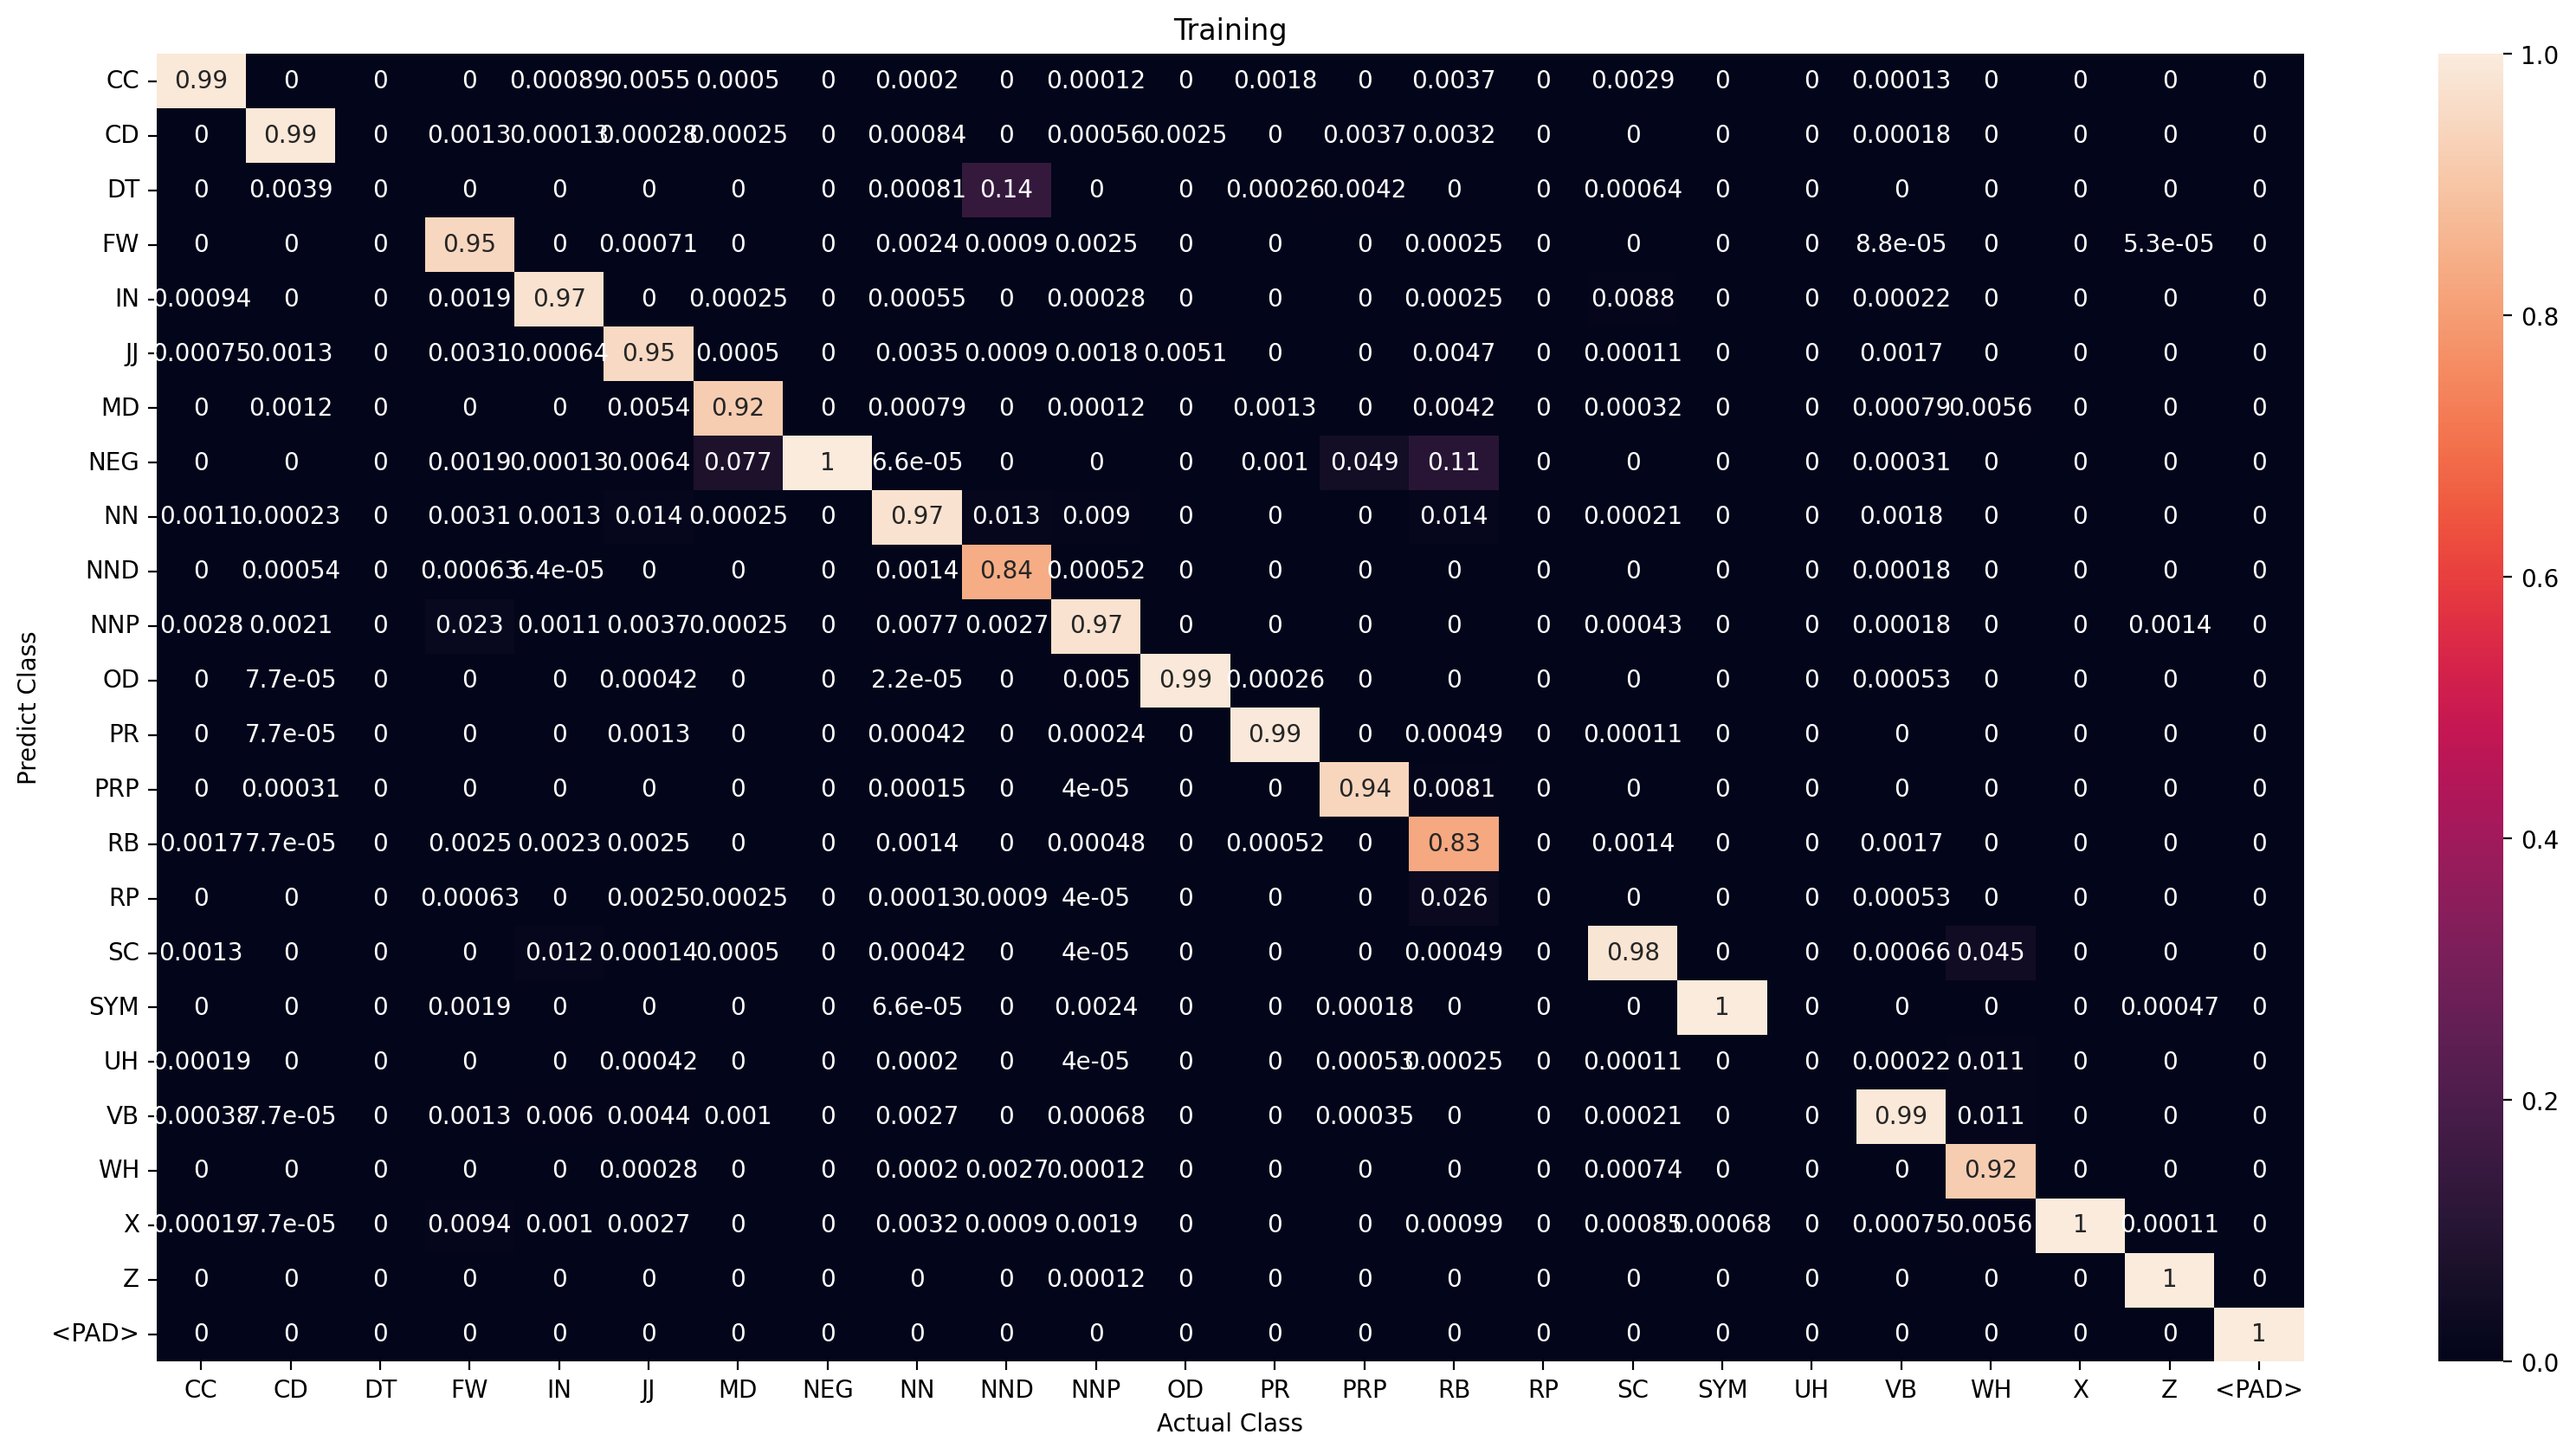

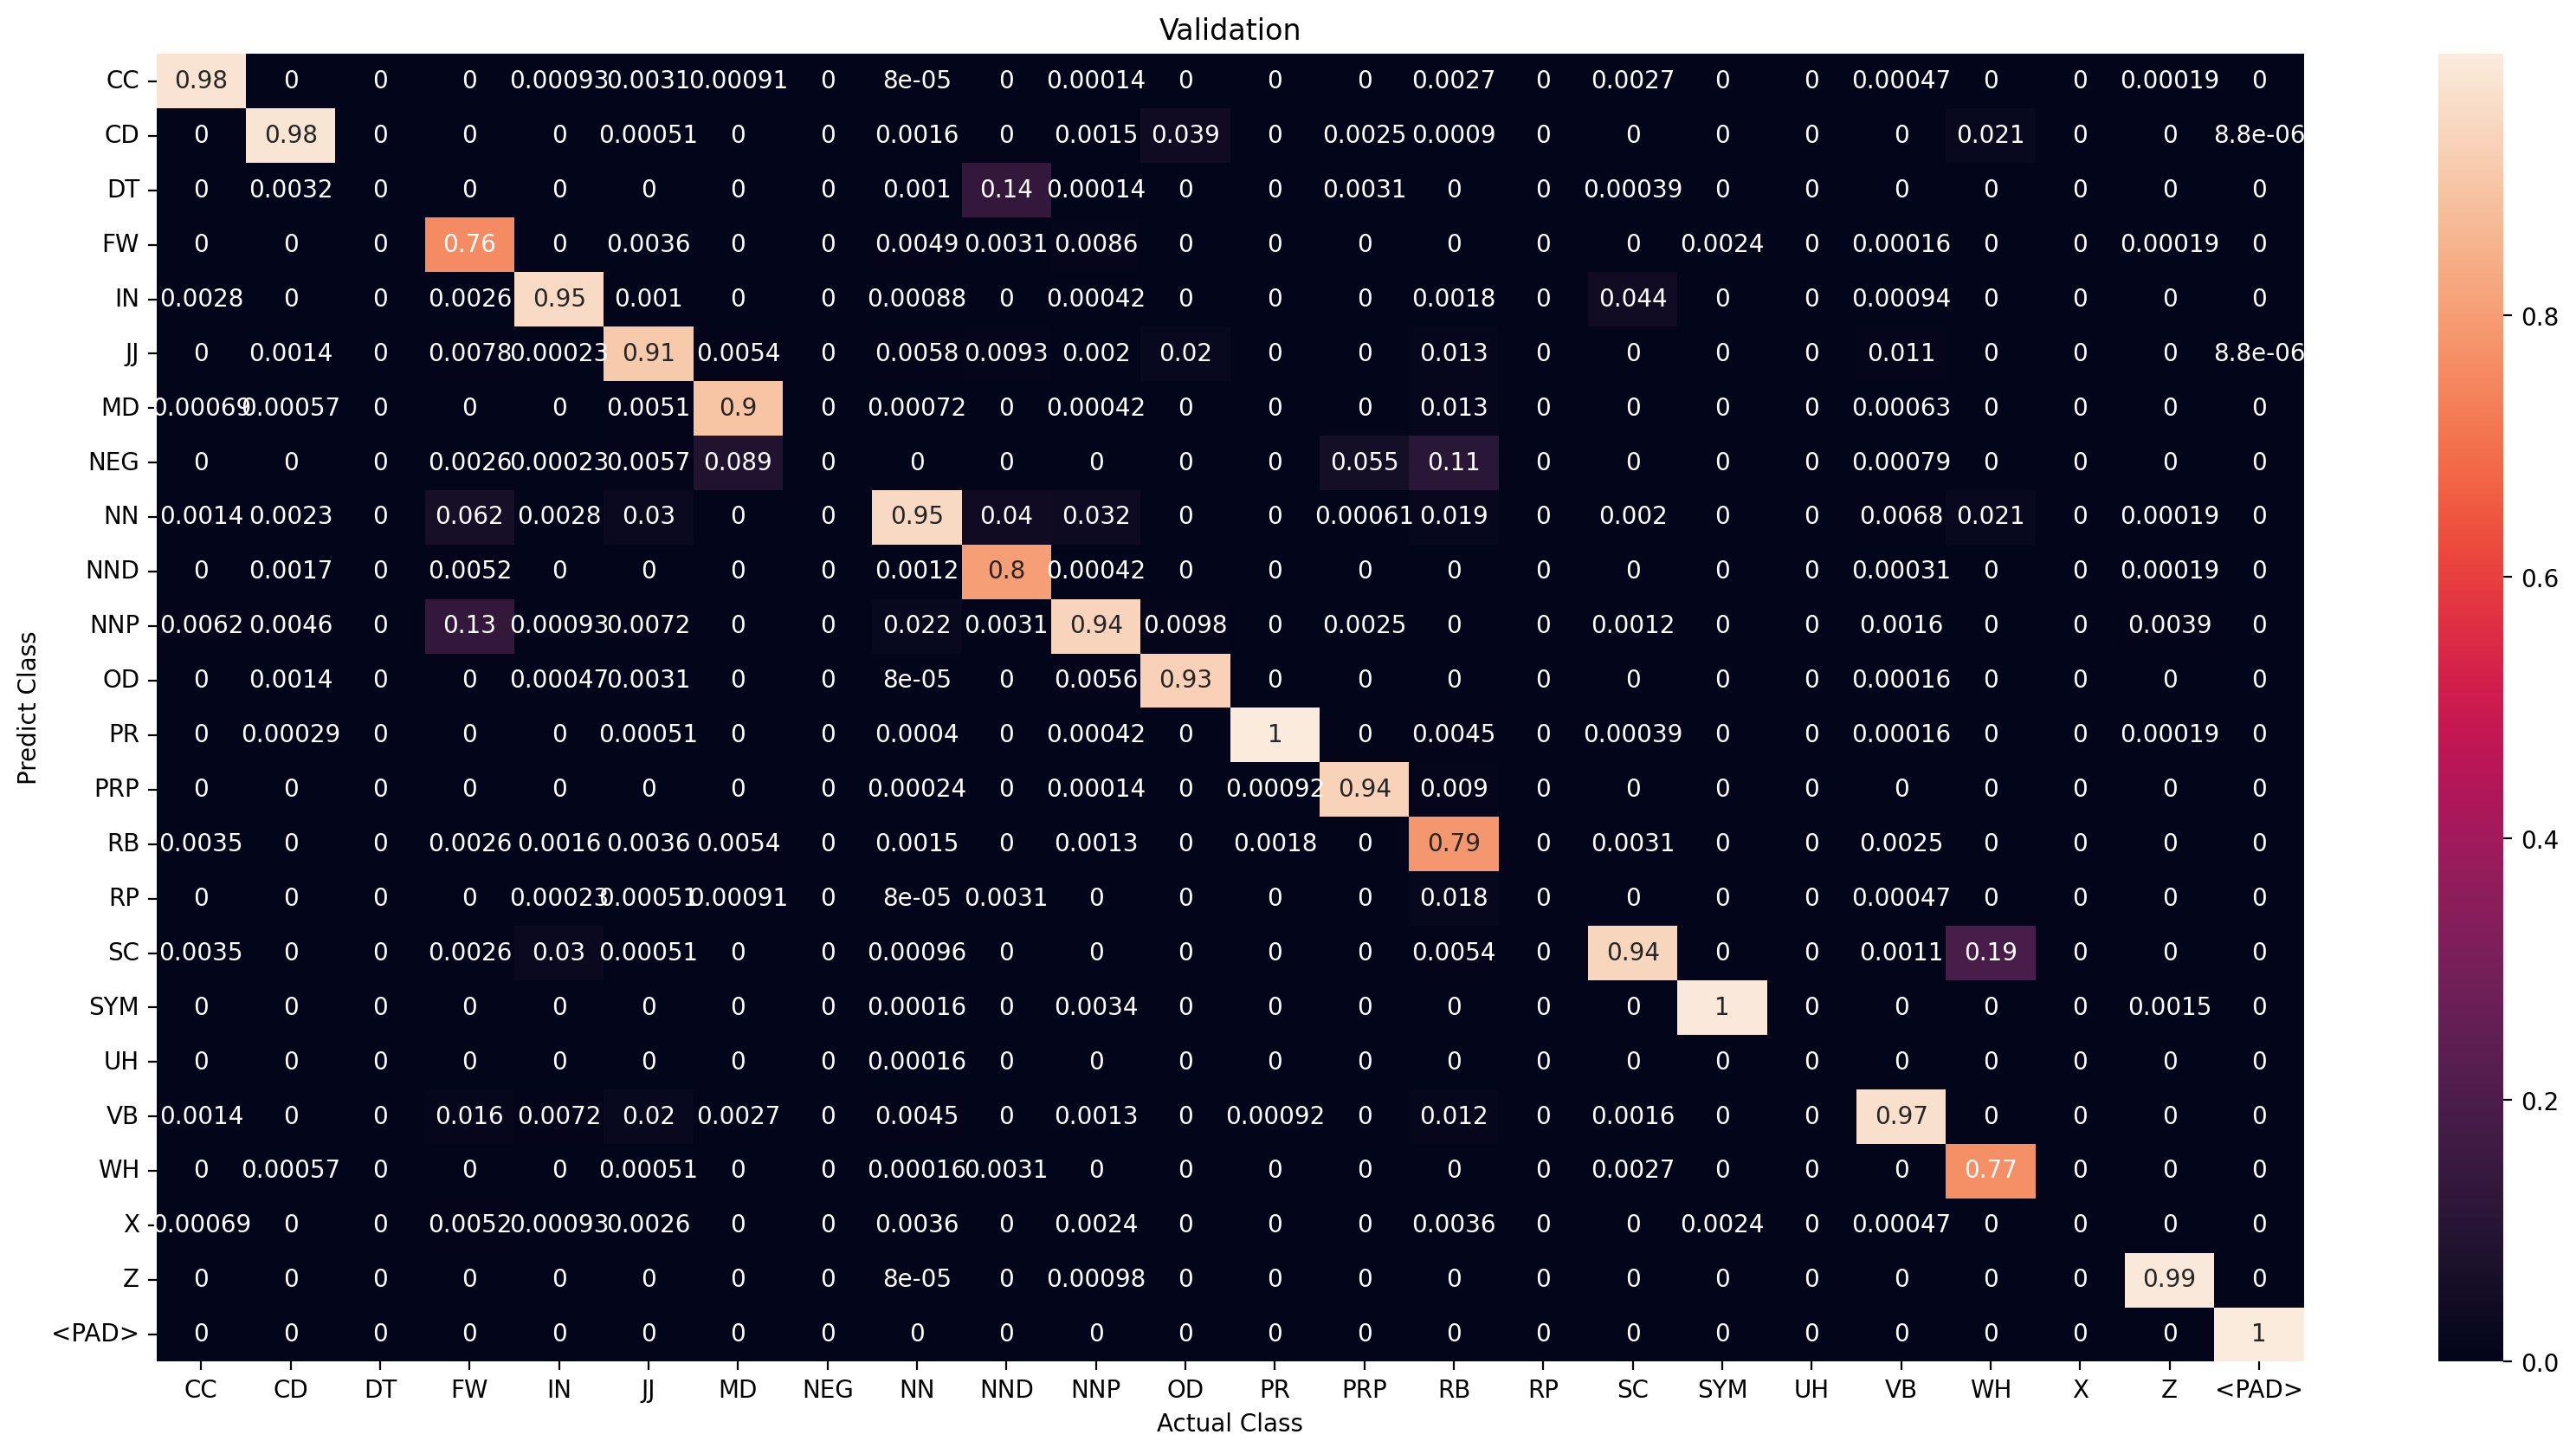

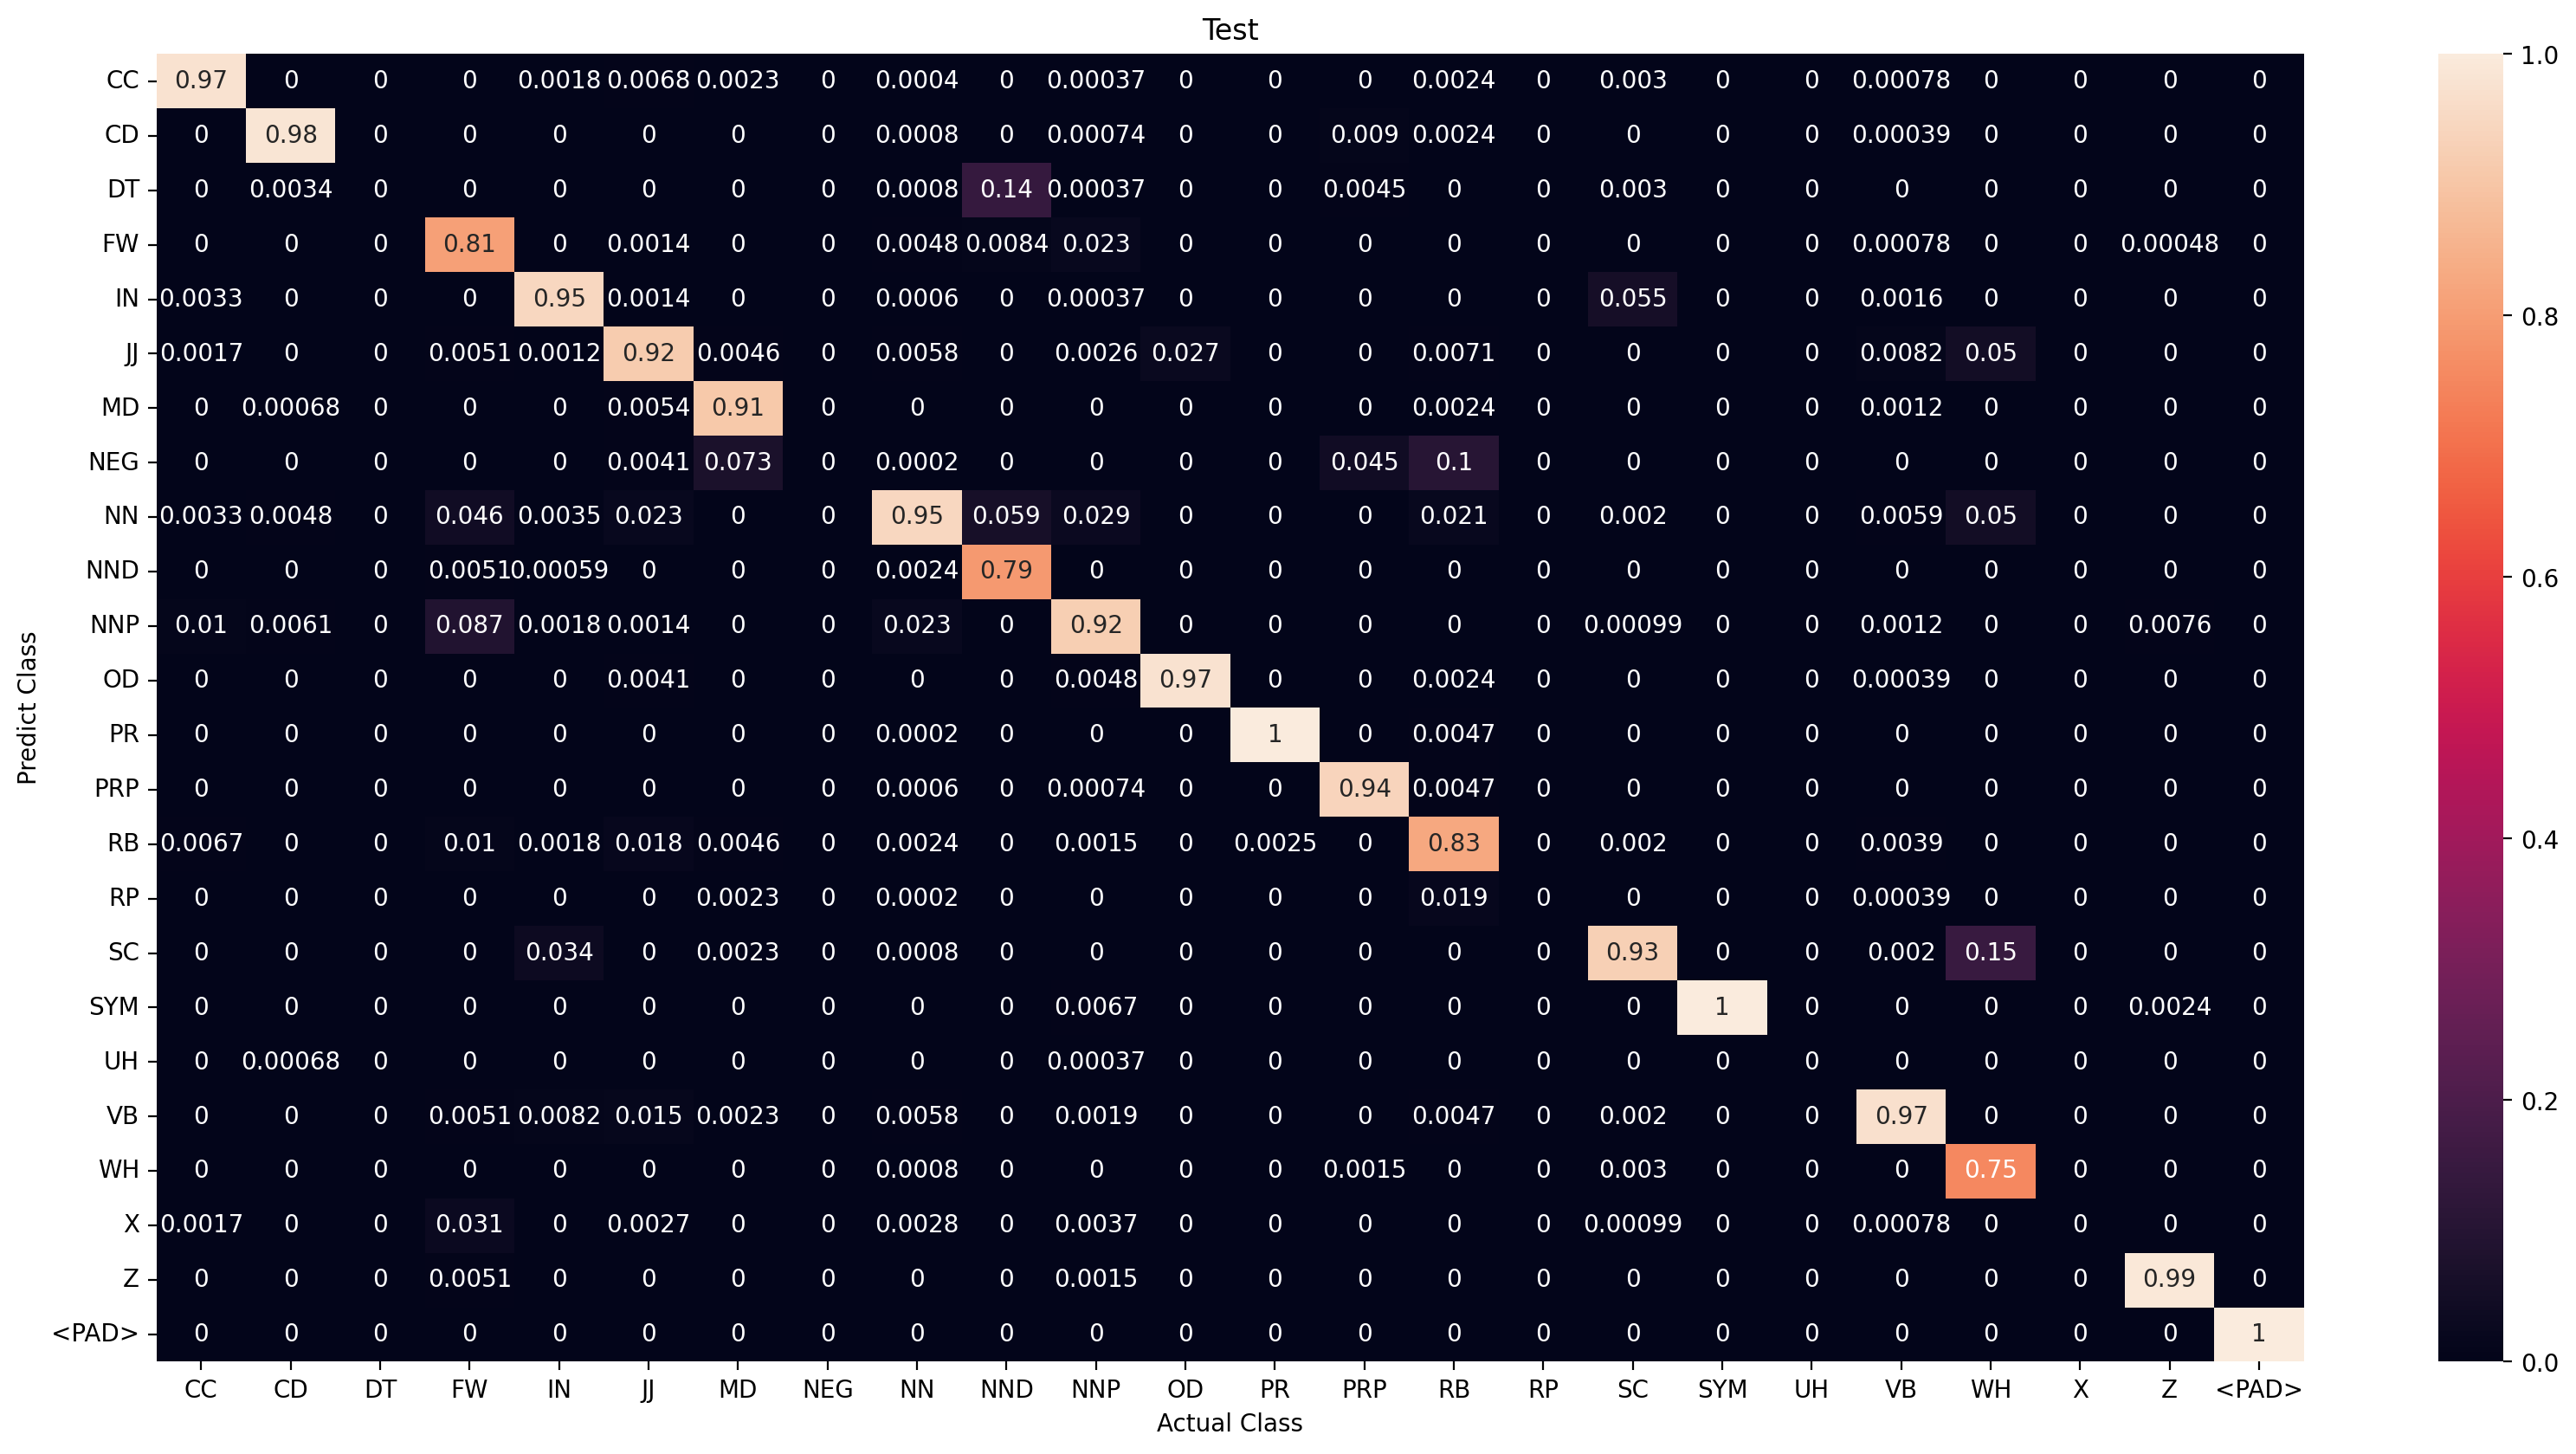

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5272       | CC    : 119      |
| CD    : 12882  | CD    : 12784      | CD    : 98       |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1511       | FW    : 179      |
| IN    : 15403  | IN    : 15273      | IN    : 130      |
| JJ    : 7018   | JJ    : 6716       | JJ    : 302      |
| MD    : 3810   | MD    : 3674       | MD    : 136      |
| NEG   : 1082   | NEG   : 1          | NEG   : 1081     |
| NN    : 44728  | NN    : 44257      | NN    : 471      |
| NND   : 1019   | NND   : 931        | NND   : 88       |
| NNP   : 24885  | NNP   : 24377      | NNP   : 508      |
| OD    : 534    | OD    : 390        | OD    : 144      |
| PR    : 3842   | PR    : 3804       | PR    : 38       |
| PRP   : 5405   | PRP   : 5360       | PRP   : 45       |
| RB    : 3553   | RB    : 3357       | RB    : 196      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11207
Wrong prediction            : 601
Percentage correct oov pred : 94.91023035230353

Validation
Number OOV token            : 3395
Correct prediction          : 3028
Wrong prediction            : 367
Percentage correct oov pred : 89.18998527245951

Test
Number OOV token            : 1359
Correct prediction          : 1205
Wrong prediction            : 154
Percentage correct oov pred : 88.66813833701251



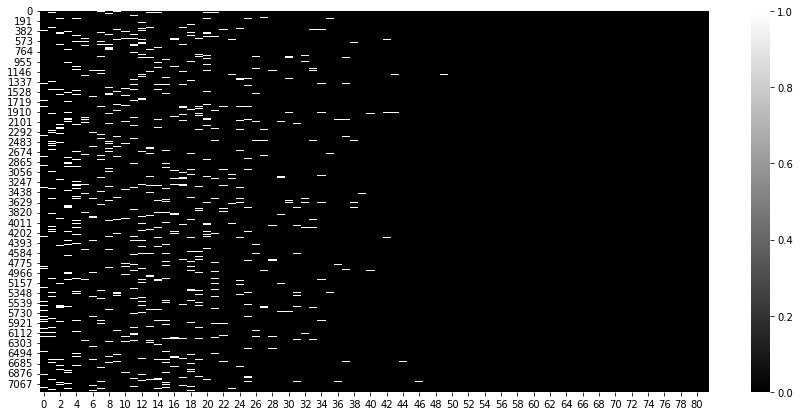

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

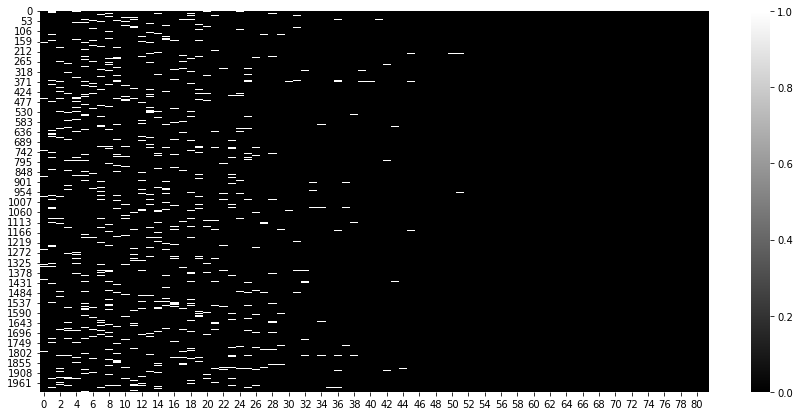

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

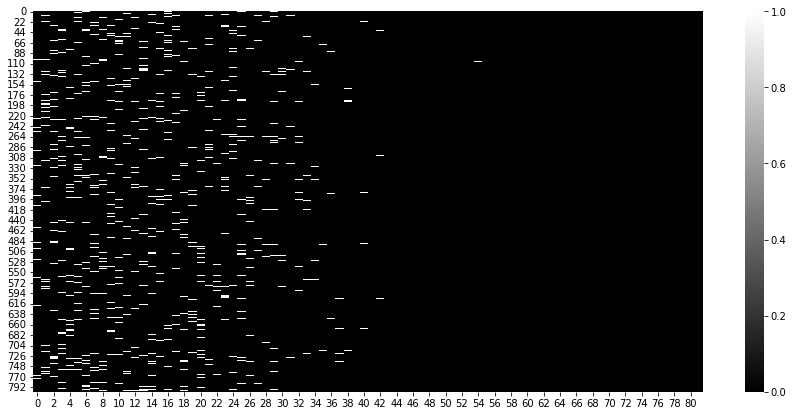

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);